![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 2 -- Grupo 18 -- Clasificación de género de películas

El propósito de este proyecto es que puedan poner en práctica, en sus respectivos grupos de trabajo, sus conocimientos sobre técnicas de preprocesamiento, modelos predictivos de NLP, y la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 2: Clasificación de género de películas"

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 8. Sin embargo, es importante que avancen en la semana 7 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 8, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/2c54d005f76747fe83f77fbf8b3ec232).

## Datos para la predicción de género en películas

#### explicación del proyecto

![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/moviegenre.png)

En este proyecto se usará un conjunto de datos de géneros de películas. Cada observación contiene el título de una película, su año de lanzamiento, la sinopsis o plot de la película (resumen de la trama) y los géneros a los que pertenece (una película puede pertenercer a más de un género). Por ejemplo:
- Título: 'How to Be a Serial Killer'
- Plot: 'A serial killer decides to teach the secrets of his satisfying career to a video store clerk.'
- Generos: 'Comedy', 'Crime', 'Horror'

La idea es que usen estos datos para predecir la probabilidad de que una película pertenezca, dada la sinopsis, a cada uno de los géneros.

Agradecemos al profesor Fabio González, Ph.D. y a su alumno John Arevalo por proporcionar este conjunto de datos. Ver https://arxiv.org/abs/1702.01992

## Preprocesamiento de datos

#### Ejemplo predicción conjunto de test para envío a Kaggle
En esta sección encontrarán el formato en el que deben guardar los resultados de la predicción para que puedan subirlos a la competencia en Kaggle.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
%%capture
!pip install neattext
!pip install scikit-multilearn

In [2]:
# Importación librerías
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Cargando los datos & Explorando los datos

In [3]:
# Carga de datos de archivo .csv
dataTraining = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv('https://github.com/albahnsen/MIAD_ML_and_NLP/raw/main/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)

In [16]:
# Visualización datos de entrenamiento
dataTraining.head()

,year,title,plot,genres,rating
3107,2003,Most,most is the story of a single father who takes...,"[Short, Drama]",8.0
900,2008,How to Be a Serial Killer,a serial killer decides to teach the secrets o...,"[Comedy, Crime, Horror]",5.6
6724,1941,A Woman's Face,"in sweden , a female blackmailer with a disfi...","[Drama, Film-Noir, Thriller]",7.2
4704,1954,Executive Suite,"in a friday afternoon in new york , the presi...",[Drama],7.4
2582,1990,Narrow Margin,"in los angeles , the editor of a publishing h...","[Action, Crime, Thriller]",6.6


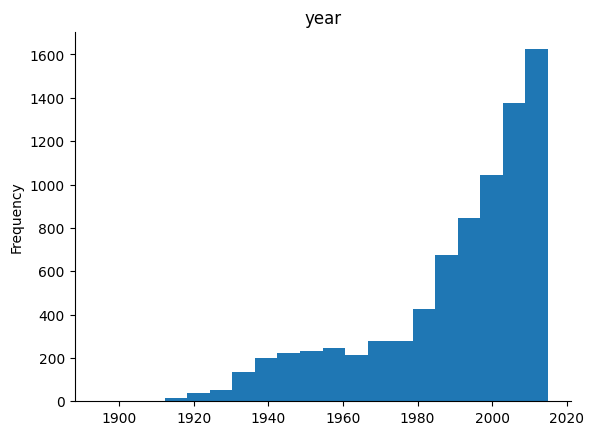

In [17]:
# @title year

from matplotlib import pyplot as plt
dataTraining['year'].plot(kind='hist', bins=20, title='year')
plt.gca().spines[['top', 'right',]].set_visible(False)

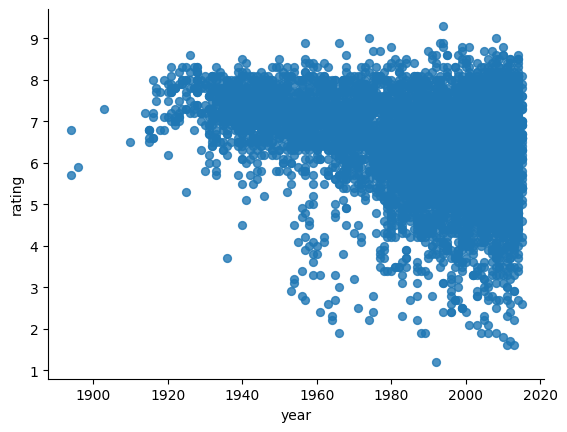

In [15]:
# @title year vs rating

from matplotlib import pyplot as plt
dataTraining.plot(kind='scatter', x='year', y='rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
# Visualización datos de test
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


Al visualizar los datos de entrenamiento y prueba vemos que: en ambas bases de datos tenemos año (year), el título (title) y la sinapsis (plot) de la película en los dos conjuntos, solo que en entrenamiento tenemos adicional la  variable rating (puntuación)y las variables de predicción en este caso los tipos de generos posibles (genres)

In [6]:
# Definición de variables predictoras (X)
vect = CountVectorizer(max_features=1000)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [19]:
# Definición de variable de interés (y)
# Convert strings to lists, but leave lists as is
dataTraining['genres'] = dataTraining['genres'].apply(lambda x: eval(x) if isinstance(x, str) else x)
le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

### Eliminación de stopwords

In [20]:
import neattext as nt
import neattext.functions as nfx

In [21]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

In [22]:
# nt.TextFrame(x).noise_scan() analiza el ruido en el texto, identificando posibles palabras o caracteres no deseados.
dataTraining['plot'].apply(lambda x: nt.TextFrame(x).noise_scan())

# nt.TextExtractor(x).extract_stopwords() extrae las palabras vacías (stopwords) del texto utilizando la clase TextExtractor de nt.
dataTraining['plot'].apply(lambda x: nt.TextExtractor(x).extract_stopwords())

# Esta función elimina las palabras vacías (stopwords) del texto, limpiando el texto para el procesamiento.
dataTraining['plot'].apply(nfx.remove_stopwords)

# Crea una nueva variable 'corpus' que contiene el resultado de aplicar remove_stopwords a cada elemento de la columna 'plot'
# Este corpus es una versión limpia del texto sin palabras vacías, lista para ser utilizada en el modelo de vectorización y clasificación.
corpus = dataTraining['plot'].apply(nfx.remove_stopwords)

### Inicialización del Vectorizador TF-IDF

In [23]:
tfidf = TfidfVectorizer()

### Ajuste del Vectorizador al Corpus

In [24]:
Xfeat = tfidf.fit(corpus)
#X feat son los atributos o features de la variable X

### Guardar modelo de vectorización

In [25]:
import os
import joblib

# Create the directory if it doesn't exist
if not os.path.exists('model_deployment'):
    os.makedirs('model_deployment')

joblib.dump(Xfeat, 'model_deployment/Xfeat.pkl', compress=3)
#grabar pkl o modelo en git model_deployment

['model_deployment/Xfeat.pkl']

In [26]:
# Vectorización utilizando TfidfVectorizer
tfidf = TfidfVectorizer()
Xfeatures = tfidf.fit_transform(corpus).toarray()

In [27]:
Xfeatures

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Tratamiento con tokens

In [28]:
import nltk

In [29]:
import pandas as pd
import numpy as np
import json
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix


In [30]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
tokenizer = ToktokTokenizer()
STOPWORDS = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

#vamos a quitar espacios, estandarizar textos con mínusculas en genral limipiar datos
def limpiar_texto(texto):

    texto = re.sub(r'\W', ' ', str(texto))

    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)

    texto = re.sub(r'\s+', ' ', texto, flags=re.I)

    texto = texto.lower()
    return texto

def filtrar_stopword_digitos(tokens):
    return [token for token in tokens if token not in STOPWORDS
            and not token.isdigit()]

def stem_palabras(tokens):
    return [stemmer.stem(token) for token in tokens]

def tokenize(texto):
    text_cleaned = limpiar_texto(texto)
    tokens = [word for word in tokenizer.tokenize(text_cleaned) if len(word) > 1]
    tokens = filtrar_stopword_digitos(tokens)
    stems = stem_palabras(tokens)
    return stems

In [32]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [33]:
# Definición de variables predictoras (X)
vect = TfidfVectorizer(tokenizer=tokenize,sublinear_tf=True,max_features=15000)
X_dtm = vect.fit_transform(dataTraining['plot']).toarray()
X_dtm.shape

(7895, 15000)

### Separación y validación de datos en el modelo

In [34]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

### Modelo RandomForestClassifier

In [35]:
# Definición y entrenamiento
clf = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42))
clf.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres = clf.predict_proba(X_test)

# Impresión del desempeño del modelo
print(roc_auc_score(y_test_genres, y_pred_genres, average='macro'))

# transformación variables predictoras X del conjunto de test
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = clf.predict_proba(X_test_dtm)

# Guardar predicciones en formato exigido en la competencia de kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_RF.csv', index_label='ID')
# res.head()

0.8167568769904546


### Modelo de regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib
import numpy as np

base_model = LogisticRegression(random_state=42)

model = OneVsRestClassifier(base_model)

param_dist = {
    "estimator__penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "estimator__C": np.logspace(-4, 4, 20),
    "estimator__solver": ['lbfgs', 'liblinear', 'saga'],
    "estimator__max_iter": [100, 200, 300, 500]
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50,
                                   scoring='roc_auc', n_jobs=-1, cv=3, random_state=42, verbose=1)

random_search.fit(X_train, y_train_genres)

MRL = random_search.best_estimator_

y_pred_genres = MRL.predict_proba(X_test)

roc_auc = roc_auc_score(y_test_genres, y_pred_genres, average='macro')
print(f'ROC-AUC Score: {roc_auc}')

joblib.dump(MRL, 'movie_genre_MRL.pkl', compress=3)

OneVsRestClassifier(estimator=LogisticRegression(random_state=42))

In [ ]:
# transformación variables predictoras X del conjunto de test
X_test_dtm = tfidf.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

# Predicción del conjunto de test
y_pred_test_genres = MRL.predict_proba(X_test_dtm)

In [ ]:

# Guardar predicciones en formato exigido en la competencia de Kaggle
res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('pred_genres_text_MRL4_26.csv', index_label='ID')
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,...,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.118906,0.091940,0.028154,0.040843,0.338875,0.118409,0.039800,0.544789,0.062132,0.120078,...,0.039186,0.078791,0.000681,0.548910,0.062577,0.012104,0.025324,0.182757,0.030925,0.030185
4,0.144365,0.058738,0.029806,0.102112,0.256749,0.307222,0.056382,0.738892,0.043368,0.037717,...,0.034057,0.045585,0.000696,0.113574,0.030402,0.011689,0.029225,0.222783,0.050337,0.035587
5,0.115259,0.050894,0.019201,0.052019,0.186162,0.556576,0.034139,0.770691,0.033442,0.041781,...,0.023579,0.300214,0.000677,0.151438,0.073453,0.010014,0.023401,0.495128,0.031696,0.025169
6,0.116990,0.097831,0.020185,0.042219,0.234858,0.087335,0.042486,0.710475,0.054216,0.056800,...,0.033132,0.104460,0.000675,0.243425,0.087850,0.008402,0.031762,0.335164,0.065932,0.020419
7,0.079485,0.071038,0.025683,0.028432,0.210374,0.129143,0.035440,0.397787,0.059006,0.123337,...,0.027689,0.158501,0.000678,0.193445,0.289660,0.010824,0.018056,0.374319,0.027744,0.022711


### Modelo de redes neuronales

In [ ]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
X_train, X_test, y_train_genres, y_test_genres = train_test_split(Xfeatures, y_genres, test_size=0.33, random_state=42)

In [ ]:
# Definición del modelo de redes neuronales
def create_nn_model(input_dim, output_dim, neurons=64, activation='relu', optimizer='adam', loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(output_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

# Crear el modelo
input_dim = X_train.shape[1]
output_dim = y_train_genres.shape[1]
model = create_nn_model(input_dim, output_dim)

# Definición de la función EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=2)

# Entrenamiento del modelo de redes neuronales
history = model.fit(X_train, y_train_genres,
                    validation_data=(X_test, y_test_genres),
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stopping],
                    verbose=True)

# Predicción en el conjunto de prueba
y_pred_genres = model.predict(X_test)

# Impresión del desempeño del modelo
roc_auc = roc_auc_score(y_test_genres, y_pred_genres, average='macro')
print("ROC AUC Score: ", roc_auc)

# Generar las predicciones para el conjunto de prueba de Kaggle
X_test_dtm = tfidf.transform(dataTesting['plot'])  # Vectorización utilizando TfidfVectorizer
y_pred_test_genres = model.predict(X_test_dtm.toarray())  # Predicción del conjunto de prueba

# Guardar las predicciones en un archivo CSV con el formato exigido por Kaggle
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

res = pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols)
res.to_csv('kaggle_submissionRN.csv', index_label='ID')

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.1334 - loss: 0.5879 - val_accuracy: 0.1926 - val_loss: 0.2998
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.2057 - loss: 0.2905 - val_accuracy: 0.1926 - val_loss: 0.2910
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.2235 - loss: 0.2704 - val_accuracy: 0.2084 - val_loss: 0.2752
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3403 - loss: 0.2319 - val_accuracy: 0.3258 - val_loss: 0.2492
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.4452 - loss: 0.1805 - val_accuracy: 0.3603 - val_loss: 0.2343
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5158 - loss: 0.1342 - val_accuracy: 0.3853 - val_loss: 0.2327
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.5444 - loss: 0.0968 - val_accuracy: 0.3810 - val_loss: 0.2390
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.5516 - loss: 0.0713 - val_accuracy: 0.3860 - 

### Calibración del modelo con mayor AUC

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
 !pip install livelossplot

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras  # Import after installing the package

def nn_model_params(optimizer, neurons, batch_size, epochs, activation, patience, loss):
    K.clear_session()

    model = Sequential()
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(output_var, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss=loss)

    early_stopping = EarlyStopping(monitor="val_loss", patience=patience)

    model.fit(X_train, y_train_genres,
              validation_data=(X_test, y_test_genres),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping, PlotLossesKeras()],
              verbose=True)

    return model

In [ ]:
nn_params = {
    'optimizer': ['adam', 'sgd'],
    'activation': ['relu'],
    'batch_size': [64, 128],
    'neurons': [64, 256],
    'epochs': [20, 50],
    'patience': [2, 5],
    'loss': ['binary_crossentropy']
}


In [ ]:
dims = X_train.shape[1]
print(dims, 'input variables')

output_var = y_train_genres.shape[1]
print(output_var, 'output variables')


38358 input variables
24 output variables


In [ ]:
!pip install tensorflow scikit-learn livelossplot

In [ ]:
!pip install scikeras

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

In [ ]:
#Arquitectura modelo

def create_model(optimizer='adam', dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Use the correct number of classes
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def create_model(input_dim, output_dim, optimizer='adam', dropout_rate=0.0, neurons=64, activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=input_dim, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# instancia KerasClassifier para API
nn_model = KerasClassifier(build_fn=create_model, input_dim=X_train.shape[1], output_dim=num_classes, verbose=0)



In [ ]:
# Define parámetro grid RandomizedSearchCV

nn_params = {
    'model__optimizer': ['adam', 'rmsprop'],
    'model__dropout_rate': [0.0, 0.2, 0.4],
    'model__neurons': [32, 64, 128],
    'model__activation': ['relu', 'tanh'],
    'epochs': [10, 20],
    'batch_size': [32, 64]
}


In [ ]:

# RandomizedSearchCV

rs = RandomizedSearchCV(estimator=nn_model,
param_distributions=nn_params,
n_iter=5,
scoring='neg_mean_squared_error',
cv=5,
n_jobs=-1)

In [ ]:
rs

RandomizedSearchCV(cv=5,
                   estimator=KerasClassifier(build_fn=<function create_model at 0x7e5341beec20>, input_dim=38358, output_dim=24, verbose=0),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'batch_size': [32, 64],
                                        'epochs': [10, 20],
                                        'model__activation': ['relu', 'tanh'],
                                        'model__dropout_rate': [0.0, 0.2, 0.4],
                                        'model__neurons': [32, 64, 128],
                                        'model__optimizer': ['adam',
                                                             'rmsprop']},
                   scoring='neg_mean_squared_error')

In [ ]:
from sklearn.metrics import roc_auc_score

### Regresión lógistica

In [ ]:
from sklearn.linear_model import LogisticRegression

# Definición y entrenamiento
lr = OneVsRestClassifier(LogisticRegression(max_iter=5000,solver='liblinear',tol=0.000001))
lr.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_lr = lr.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_lr, average='macro')

0.878230957783155

### Red neuronal

In [ ]:
from sklearn.neural_network import MLPClassifier

# Definición y entrenamiento
rn = OneVsRestClassifier(MLPClassifier(max_iter=1000, random_state=42))
rn.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres = rn.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_rn, average='macro')

### XGBoost

In [ ]:
from xgboost import XGBClassifier

# Definición y entrenamiento
xgb = XGBClassifier(learning_rate= 0.01, colsample_bytree= 0.7999999999999999,n_estimators= 500,subsample=0.7999999999999999,colsample_bylevel=0.7,max_depth=15)
xgb.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_xgb = xgb.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_xgb, average='macro')

0.8045429016347838

### Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Definición y entrenamiento
gb = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
gb.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_gb = gb.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_gb, average='macro')

0.7752809591506488

### CatBoost

In [ ]:
!pip install catboost

from catboost import CatBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
# Definición y entrenamiento
cbt = OneVsRestClassifier(CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42))
cbt.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_cbt = cbt.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_cbt, average='macro')

AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Definición y entrenamiento
adb = OneVsRestClassifier(AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
adb.fit(X_train, y_train_genres)

# Predicción del modelo de clasificación
y_pred_genres_adb = adb.predict_proba(X_test)

# Impresión del desempeño del modelo
roc_auc_score(y_test_genres, y_pred_genres_adb, average='macro')

0.7701094207998874

### Disponibilización en API del modelo

In [ ]:
pip install flask_restx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 3.0 MB/s eta 0:00:00


In [ ]:
pip install flask

In [ ]:
from flask import Flask
from flask_restx import Api, Resource, fields

In [ ]:
pip install joblib

In [ ]:
# Exportar modelo
import joblib

from flask import Flask
from flask_restx import Api, Resource, fields
import sys
import os
import joblib
import pandas as pd

import neattext as nt
import neattext.functions as nfx
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
MRL

OneVsRestClassifier(estimator=LogisticRegression(random_state=42))

In [ ]:
# Exportar modelo a archivo binario .pkl
joblib.dump(MRL, 'movie_genre_MRL2.pkl', compress=3)

['movie_genre_MRL2.pkl']



### Disponibilización del API con el modelo de forma local

In [ ]:
!pip install flask-restx

from flask import Flask
from flask_restx import Api, Resource, fields
import pandas as pd
import joblib

In [ ]:
app = Flask(__name__)
api = Api(app, version='1.0', title='API_Géneros de Películas', description='Predicción del género de las pelìculas según la sipnósis')
ns = api.namespace('predicción', description='Género de la película')
parser = api.parser()

In [ ]:
parser.add_argument(
    'URL',
    type=str,
    required=True,
    help='Data to be analyzed',
    location='args'
)

resource_fields = api.model('Resource', {
    'result': fields.String,
})

In [ ]:
@ns.route('/')
class MovieGenreApi(Resource):
    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        plot = args['Plot']
        prediction = predict_genre(plot)
        return {"result": prediction.to_dict()}, 200

In [ ]:
#Se usa mejor con una aplicación para subir la API en la nube con un archivo serveless y endpoint